# Mini projeto 3

Prevendo a cotação de criptomoedas em tempo real com PySpark e Machine Learning

In [1]:
# Importando bibliotecas:
from platform import python_version
print('Versão Python:', python_version(), '\n')

import findspark
findspark.init() # Inicializando o findspark

import pyspark
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from pyspark import SparkConf, SparkContext # SparkConf: Configuração do Spark; SparkContext: Contexto do Spark
from pyspark.sql import SparkSession, SQLContext # SparkSession: Sessão do Spark; SQLContext: Contexto SQL
from pyspark.sql.types import * # Importando todos os tipos de dados do Spark
from pyspark.sql.functions import * # Importando todas as funções do Spark
from pyspark.ml.linalg import Vectors # Importando o tipo de dado vetor do Spark
from pyspark.ml.feature import StringIndexer # Importando o indexador de string do Spark
from pyspark.ml.regression import LinearRegression # Importando a regressão linear do Spark
from pyspark.mllib.evaluation import RegressionMetrics # Importando as métricas de avaliação do Spark
from pyspark.ml.linalg import Vectors # Importando o tipo de dado vetor do Spark
from pyspark.ml.feature import StringIndexer # Importando o indexador de string do Spark
from pyspark.ml.stat import Correlation # Importando a correlação do Spark
from pyspark.ml.feature import MinMaxScaler # Importando o escalonador do Spark
from pyspark.ml.feature import VectorAssembler # Importando o montador de vetores do Spark
from pyspark.ml import Pipeline # Importando o pipeline do Spark
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel # Importando o otimizador de hiperparâmetros do Spark
from pyspark.ml.feature import VectorAssembler, StandardScaler # Importando o montador de vetores e o escalonador do Spark
from pyspark.ml.evaluation import RegressionEvaluator # Importando o avaliador de regressão do Spark

%reload_ext watermark
%watermark -a "gustavogzr" --iversions

Versão Python: 3.11.1 

Author: gustavogzr

seaborn   : 0.12.2
numpy     : 1.25.2
findspark : 2.0.1
sys       : 3.11.1 (tags/v3.11.1:a7a450f, Dec  6 2022, 19:58:39) [MSC v.1934 64 bit (AMD64)]
decimal   : 1.70
pyspark   : 3.5.2
matplotlib: 3.7.2
pandas    : 2.0.3



In [2]:
# Formatação das saídas
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)
from matplotlib.axes._axes import _log as matplotlib_axes_logger # Removendo mensagens de aviso
matplotlib_axes_logger.setLevel('ERROR') # Removendo mensagens de aviso

## Preparando o ambiente Spark

In [3]:
# Definindo semente aleatória (seed) para reprodutabilidade dos resultados
rnd_seed = 23
np.random.seed = rnd_seed
np.random.set_state = rnd_seed

In [4]:
# Criando um Spark Context:
sc = SparkContext(appName='Mini-Projeto-3') # Criando um SparkContext. O parâmetro appName é um nome para a aplicação Spark

In [5]:
# Criando um Spark Session: 
spark_session = SparkSession.Builder().config("spark.driver.memory", "15g").getOrCreate() # Criando uma sessão Spark
# a diferença entre contexto e sessão é que a sessão engloba o contexto e adiciona informações sobre a aplicação

In [6]:
# Visualizando a sessão criada:
spark_session

## Carregando os dados

In [7]:
# Carregar os dados a partir da sessão Spark:
df_spark = spark_session.read.csv('.arquivos_DSA/dados/dataset.csv', header=True, inferSchema=True) # inferSchema: Infere o tipo de dado de cada coluna

In [8]:
# Tipo de objeto:
type(df_spark)

pyspark.sql.dataframe.DataFrame

In [9]:
# Visualizando os dados:
df_spark.show()

+----------+----+----+----+-----+------------+-----------------+--------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|
+----------+----+----+----+-----+------------+-----------------+--------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|
|1325319300| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319360| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319420| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319480| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319540| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319600| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319660| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325345040| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325345100| NaN| NaN| NaN|  NaN|       

In [10]:
# Visualizar metadados:
df_spark.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume_(BTC): double (nullable = true)
 |-- Volume_(Currency): double (nullable = true)
 |-- Weighted_Price: double (nullable = true)



In [11]:
# Verificar o número de linhas:
df_spark.count()

4856600

## Data Wrangling com SparkSQL (Manipulação de Dados)

In [12]:
# Criar tabela temporária a partir do dataframe:
df_spark.createOrReplaceTempView('dados_bitcoin')
# A tabela temporária é uma visão temporária que pode ser utilizada para executar consultas SQL
# Evita-se utilizar o dataframe diretamente para consultas SQL

In [13]:
# Executar consulta SQL:
df_bitcoin = spark_session.sql('SELECT *, from_unixtime(timestamp) as `dateTime` FROM dados_bitcoin')
df_bitcoin = df_bitcoin.withColumn("dateTime", from_utc_timestamp('dateTime', "UTC-6")) # Ajustando o fuso horário
df_bitcoin.show(5)

+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|           dateTime|
+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|2011-12-30 23:52:00|
|1325319300| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 00:15:00|
|1325319360| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 00:16:00|
|1325319420| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 00:17:00|
|1325319480| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 00:18:00|
+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
only showing top 5 rows



In [14]:
type(df_bitcoin)

pyspark.sql.dataframe.DataFrame

In [15]:
# Remoção de valores NaN (missing values):
df_bitcoin = df_bitcoin.dropna('any')
df_bitcoin.show(5)

+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|           dateTime|
+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|2011-12-30 23:52:00|
|1325346600|4.39|4.39|4.39| 4.39|        48.0|           210.72|          4.39|2011-12-31 07:50:00|
|1325350740| 4.5|4.57| 4.5| 4.57| 37.86229723|     171.38033753|  4.5264114983|2011-12-31 08:59:00|
|1325350800|4.58|4.58|4.58| 4.58|         9.0|            41.22|          4.58|2011-12-31 09:00:00|
|1325391360|4.58|4.58|4.58| 4.58|       1.502|          6.87916|          4.58|2011-12-31 20:16:00|
+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
only showing top 5 rows



In [16]:
# Verificar o número de linhas:
df_bitcoin.count()

3613769

In [17]:
# Colunas do dataframe:
df_bitcoin.columns

['Timestamp',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume_(BTC)',
 'Volume_(Currency)',
 'Weighted_Price',
 'dateTime']

In [18]:
# Renomear colunas para facilitar a manipulação de dados:
df_bitcoin = df_bitcoin.withColumnRenamed(
    'Volume_(BTC)', 'Vol_BTC').withColumnRenamed(
    'Volume_(Currency)', 'Vol_Currency')
df_bitcoin.show(5)

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+
| Timestamp|Open|High| Low|Close|    Vol_BTC|Vol_Currency|Weighted_Price|           dateTime|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-30 23:52:00|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31 07:50:00|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31 08:59:00|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31 09:00:00|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2011-12-31 20:16:00|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+
only showing top 5 rows



In [19]:
# Vamos dividir o dataframe extraindo a data e hora:
df_data = df_bitcoin.withColumn('date', split(col('dateTime'), ' ').getItem(0))
df_data = df_data.withColumn('time', split(col('dateTime'), ' ').getItem(1))
df_data.show(5)

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+
| Timestamp|Open|High| Low|Close|    Vol_BTC|Vol_Currency|Weighted_Price|           dateTime|      date|    time|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-30 23:52:00|2011-12-30|23:52:00|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31 07:50:00|2011-12-31|07:50:00|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31 08:59:00|2011-12-31|08:59:00|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31 09:00:00|2011-12-31|09:00:00|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2011-12-31 20:16:00|2011-12-31|20:16:00|
+----------+----+----+----+-----+-----------+------------+--------------+---------------

In [20]:
type(df_data)

pyspark.sql.dataframe.DataFrame

In [21]:
df_data.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Vol_BTC: double (nullable = true)
 |-- Vol_Currency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: timestamp (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)



In [22]:
# Extrair a hora:
df_data_hora = df_data.withColumn('hour', split(col('time'), ':').getItem(0))
df_data_hora.show(5)

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+----+
| Timestamp|Open|High| Low|Close|    Vol_BTC|Vol_Currency|Weighted_Price|           dateTime|      date|    time|hour|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+----+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-30 23:52:00|2011-12-30|23:52:00|  23|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31 07:50:00|2011-12-31|07:50:00|  07|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31 08:59:00|2011-12-31|08:59:00|  08|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31 09:00:00|2011-12-31|09:00:00|  09|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2011-12-31 20:16:00|2011-12-31|20:16:00|  20|
+----------+----+----+----+-----+-----------+---

In [23]:
df_data_hora.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Vol_BTC: double (nullable = true)
 |-- Vol_Currency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: timestamp (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)
 |-- hour: string (nullable = true)



In [24]:
# Para extrair o dia da semana é necessário ajustar o formato da data
df_data_hora = df_data_hora.withColumn( # Criando uma nova coluna
    "date", # Coluna a ser ajustada
    df_data_hora["date"].cast(DateType()) # Convertendo a coluna para o tipo Date 
).withColumn(
    "hour", # Coluna a ser ajustada
    df_data_hora["hour"].cast(DoubleType()) # Convertendo a coluna para o tipo Double
).withColumn(
    "dateTime",
    df_data_hora["dateTime"].cast(DateType())) # Convertendo a coluna para o tipo Date

df_data_hora.show(5)

+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+
| Timestamp|Open|High| Low|Close|    Vol_BTC|Vol_Currency|Weighted_Price|  dateTime|      date|    time|hour|
+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-30|2011-12-30|23:52:00|23.0|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31|2011-12-31|07:50:00| 7.0|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31|2011-12-31|08:59:00| 8.0|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31|2011-12-31|09:00:00| 9.0|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2011-12-31|2011-12-31|20:16:00|20.0|
+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+
only showi

In [25]:
# Vamos extrair o dia da semana:
df_data_hora = df_data_hora.withColumn(
    'day_week',
    dayofweek(df_data_hora.date))
df_data_hora.show(5)

+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+--------+
| Timestamp|Open|High| Low|Close|    Vol_BTC|Vol_Currency|Weighted_Price|  dateTime|      date|    time|hour|day_week|
+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+--------+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-30|2011-12-30|23:52:00|23.0|       6|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31|2011-12-31|07:50:00| 7.0|       7|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31|2011-12-31|08:59:00| 8.0|       7|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31|2011-12-31|09:00:00| 9.0|       7|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2011-12-31|2011-12-31|20:16:00|20.0|       7|
+----------+----+----+----+-----+-----------+---

In [26]:
# Vamos extrair o ano da cotação:
df_data_hora_ano = df_data_hora.withColumn(
    'year',
    split(col('date'), '-').getItem(0))
df_data_hora_ano.show(5)

+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+--------+----+
| Timestamp|Open|High| Low|Close|    Vol_BTC|Vol_Currency|Weighted_Price|  dateTime|      date|    time|hour|day_week|year|
+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+--------+----+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-30|2011-12-30|23:52:00|23.0|       6|2011|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31|2011-12-31|07:50:00| 7.0|       7|2011|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31|2011-12-31|08:59:00| 8.0|       7|2011|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31|2011-12-31|09:00:00| 9.0|       7|2011|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2011-12-31|2011-12-31|20:16:00|20.0|       7|2011|
+-------

In [27]:
# Converter dataframe para Pandas:
df_pandas = df_data_hora_ano.toPandas()
df_pandas.head()

,Timestamp,Open,High,Low,Close,Vol_BTC,Vol_Currency,Weighted_Price,dateTime,date,time,hour,day_week,year
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-30,2011-12-30,23:52:00,23.0,6,2011
1,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,2011-12-31,2011-12-31,07:50:00,7.0,7,2011
2,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411,2011-12-31,2011-12-31,08:59:00,8.0,7,2011
3,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,2011-12-31,2011-12-31,09:00:00,9.0,7,2011
4,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,2011-12-31,2011-12-31,20:16:00,20.0,7,2011


In [28]:
type(df_pandas) # Tipo do objeto

pandas.core.frame.DataFrame

In [29]:
# Ajustar algumas colunas do dataframe (criação de listas):
hour = df_pandas['hour'].values.tolist()
weight_price = df_pandas['Weighted_Price'].values.tolist()
volume_BTC = df_pandas['Vol_BTC'].values.tolist()
date_of_week = df_pandas['day_week'].values.tolist()
year = df_pandas['year'].values.tolist()

## Análise Exploratória de Dados

In [31]:
df_pandas.head()

,Timestamp,Open,High,Low,Close,Vol_BTC,Vol_Currency,Weighted_Price,dateTime,date,time,hour,day_week,year
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-30,2011-12-30,23:52:00,23.0,6,2011
1,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,2011-12-31,2011-12-31,07:50:00,7.0,7,2011
2,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411,2011-12-31,2011-12-31,08:59:00,8.0,7,2011
3,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,2011-12-31,2011-12-31,09:00:00,9.0,7,2011
4,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,2011-12-31,2011-12-31,20:16:00,20.0,7,2011


In [33]:
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3613769 entries, 0 to 3613768
Data columns (total 14 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Timestamp       int32  
 1   Open            float64
 2   High            float64
 3   Low             float64
 4   Close           float64
 5   Vol_BTC         float64
 6   Vol_Currency    float64
 7   Weighted_Price  float64
 8   dateTime        object 
 9   date            object 
 10  time            object 
 11  hour            float64
 12  day_week        int32  
 13  year            object 
dtypes: float64(8), int32(2), object(4)
memory usage: 358.4+ MB


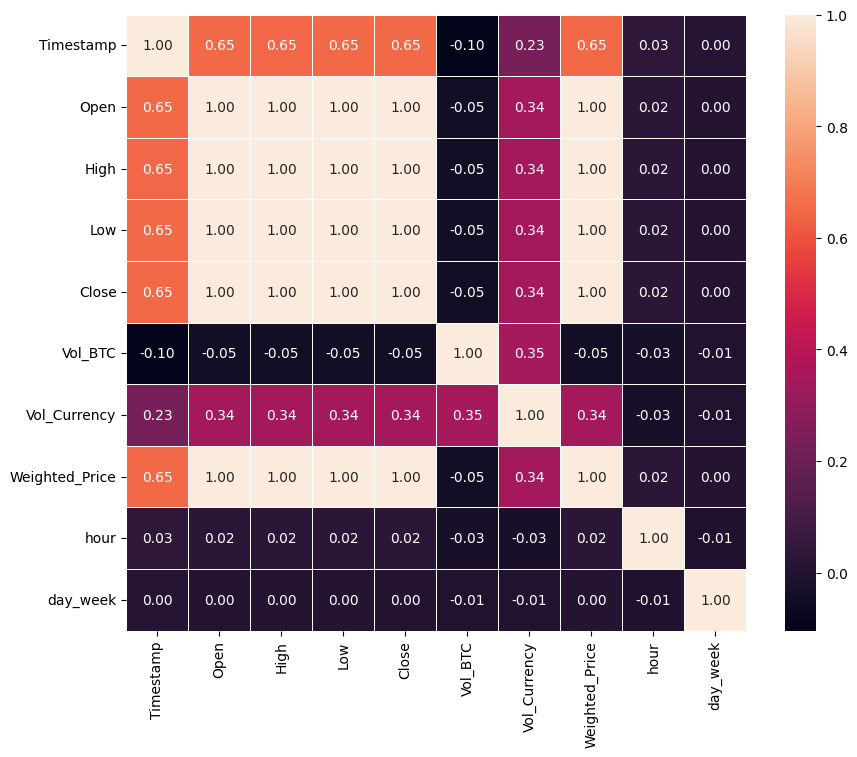

In [35]:
# Selecionar nome das colunas que são int32 ou float64:
colunas_numericas = df_pandas.select_dtypes(include=['int32', 'float64']).columns
# Criar heatmap para avaliar a correlação entre as variáveis:
corr = df_pandas[colunas_numericas].corr()
f,ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, annot=True, linewidths=.5, fmt= '.2f',ax=ax)
plt.show()

<Figure size 1200x500 with 0 Axes>

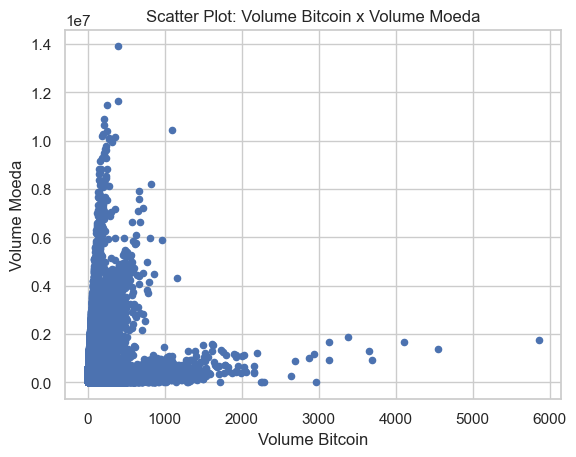

In [36]:
# Scatter plot entre Vol_BTC e Vol_Currency:
plt.figure(figsize=(12, 5))
sns.set(style="whitegrid")
df_pandas.plot(kind='scatter', x='Vol_BTC', y='Vol_Currency')
plt.xlabel('Volume Bitcoin')
plt.ylabel('Volume Moeda')
plt.title('Scatter Plot: Volume Bitcoin x Volume Moeda')
plt.show()

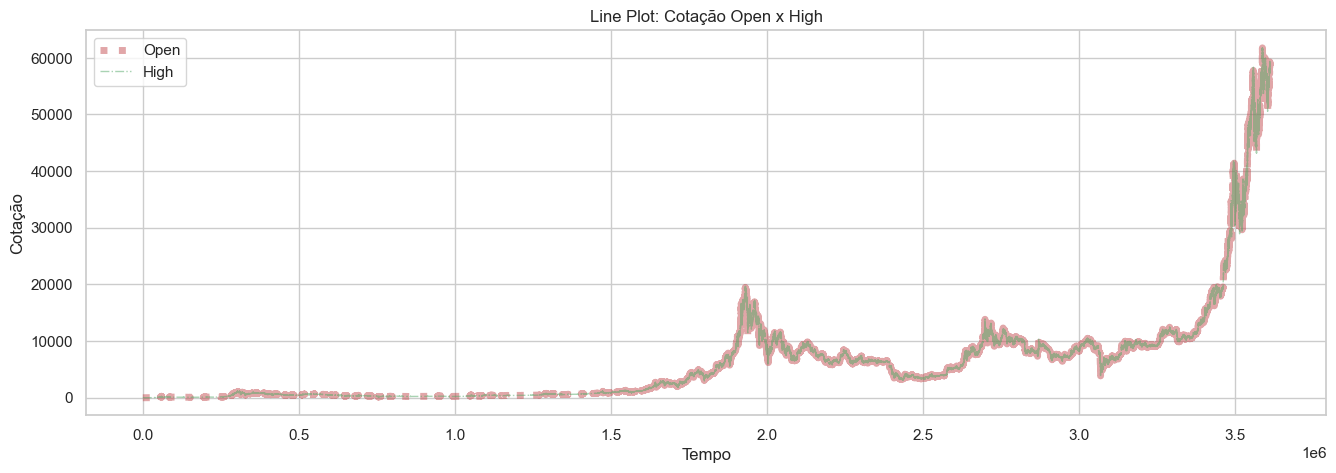

In [37]:
# Lineplot da cotação Open x High:
plt.figure(figsize=(16, 5))
df_pandas.Open.plot(
    kind='line',
    color='r',
    label='Open',
    alpha=0.5,
    linewidth=5,
    grid = True,
    linestyle = ':')
df_pandas.High.plot(
    color='g',
    label='High',
    alpha=0.5,
    linewidth=1,
    grid = True,
    linestyle = '-.')
plt.legend(loc='upper left')
plt.xlabel('Tempo')
plt.ylabel('Cotação')
plt.title('Line Plot: Cotação Open x High')
plt.show()

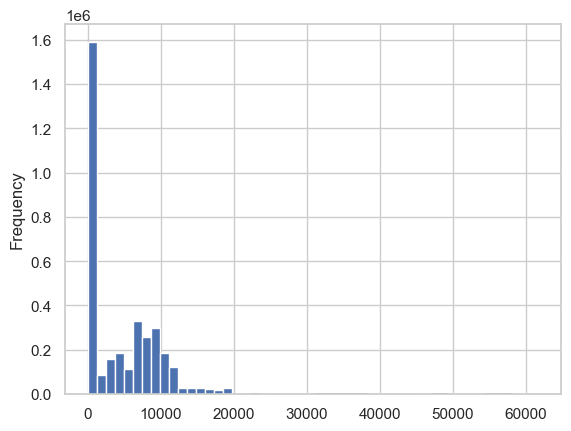

In [39]:
# Histograma da cotação Open:
df_pandas.Open.plot(kind='hist', bins=50)
plt.show()

In [40]:
df_pandas.columns

Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Vol_BTC', 'Vol_Currency',
       'Weighted_Price', 'dateTime', 'date', 'time', 'hour', 'day_week',
       'year'],
      dtype='object')

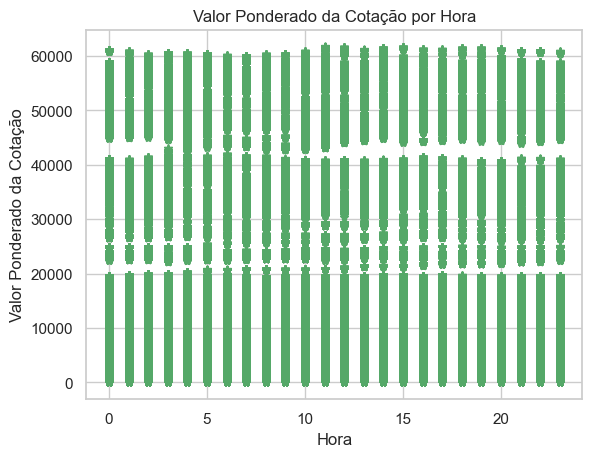

In [44]:
# Plot do valor ponderado  da cotação por hora:
plt.plot('hour', 'Weighted_Price', 'g*', data=df_pandas)
plt.xlabel('Hora')
plt.ylabel('Valor Ponderado da Cotação')
plt.title("Valor Ponderado da Cotação por Hora")
plt.show()

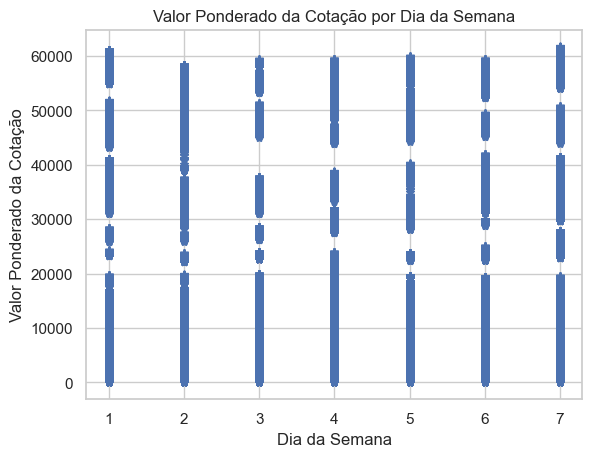

In [45]:
# Plot do valor ponderado da cotação por dia da semana:
plt.plot(date_of_week, weight_price, 'b*')
plt.xlabel('Dia da Semana')
plt.ylabel('Valor Ponderado da Cotação')
plt.title("Valor Ponderado da Cotação por Dia da Semana")
plt.show()

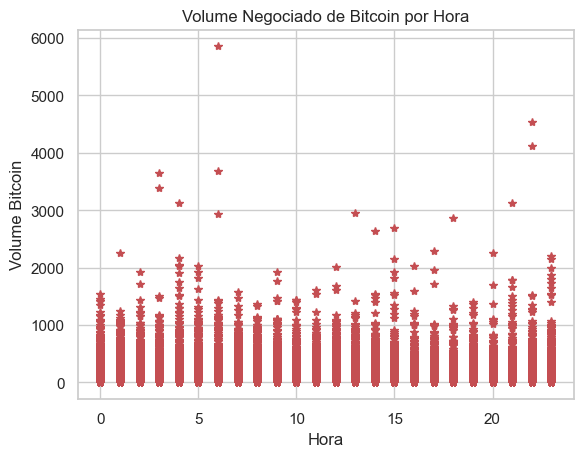

In [46]:
# Plot do Vol_BTC por hora:
plt.plot(hour, volume_BTC, 'r*')
plt.xlabel('Hora')
plt.ylabel('Volume Bitcoin')
plt.title("Volume Negociado de Bitcoin por Hora")
plt.show()

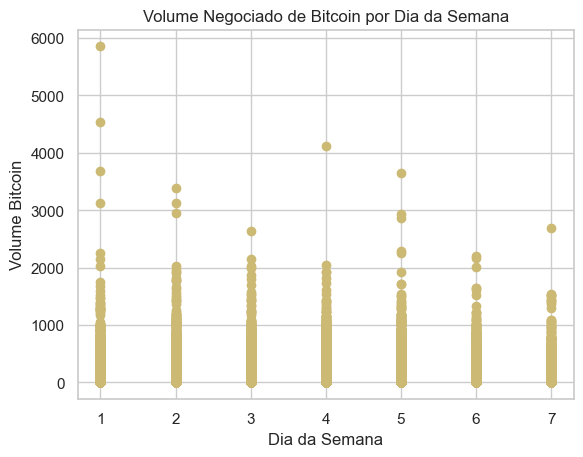

In [47]:
# Plot do Vol_BTC por dia da semana:
plt.plot(date_of_week, volume_BTC, 'yo')
plt.xlabel('Dia da Semana')
plt.ylabel('Volume Bitcoin')
plt.title("Volume Negociado de Bitcoin por Dia da Semana")
plt.show()

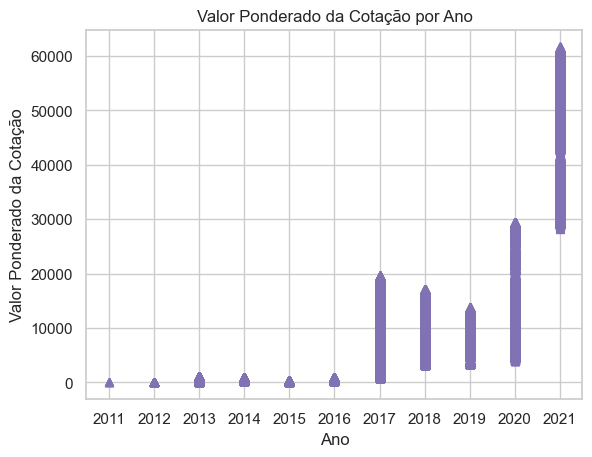

In [48]:
# Plot do valor ponderado da cotação por ano:
plt.plot(year, weight_price, 'm^')
plt.xlabel('Ano')
plt.ylabel('Valor Ponderado da Cotação')
plt.title("Valor Ponderado da Cotação por Ano")
plt.show()

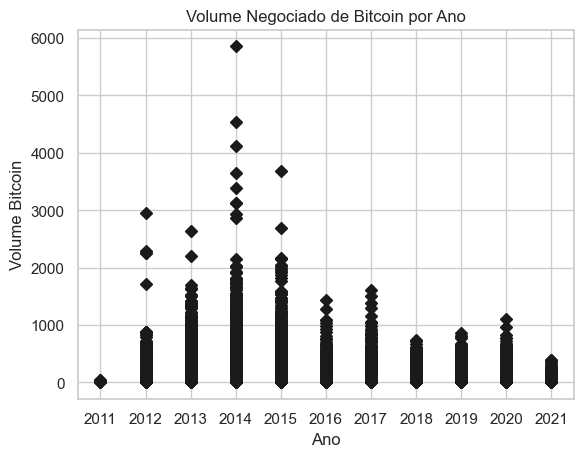

In [49]:
# Plot do volume negociado de Bitcoin por ano:
plt.plot(year, volume_BTC, 'kD')
plt.xlabel('Ano')
plt.ylabel('Volume Bitcoin')
plt.title("Volume Negociado de Bitcoin por Ano")
plt.show()

## Engenharia de Atributos com PySpark

In [52]:
# Voltamos a trabalhar com o dataframe do Spark:
df_bitcoin.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Vol_BTC: double (nullable = true)
 |-- Vol_Currency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: timestamp (nullable = true)



In [54]:
# Preparar vetor de atributos:
assembler = VectorAssembler(
    inputCols=['Open', 'Vol_BTC', 'Vol_Currency'], # as demais colunas não serão utilizadas porque não possuem correlação com a variável target
    outputCol='features')
# o VectorAssembler é uma ferramenta que combina uma lista de colunas em um único vetor de coluna

In [58]:
# Criar dataframe do vetor de atributos:
df_assembled = assembler.transform(df_bitcoin) # Aplicando o assembler ao dataframe

In [59]:
# Visualizar o dataframe:
df_assembled.show(10, truncate=False) # truncate=False: Não truncar as colunas

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+------------------------------+
|Timestamp |Open|High|Low |Close|Vol_BTC    |Vol_Currency|Weighted_Price|dateTime           |features                      |
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+------------------------------+
|1325317920|4.39|4.39|4.39|4.39 |0.45558087 |2.0000000193|4.39          |2011-12-30 23:52:00|[4.39,0.45558087,2.0000000193]|
|1325346600|4.39|4.39|4.39|4.39 |48.0       |210.72      |4.39          |2011-12-31 07:50:00|[4.39,48.0,210.72]            |
|1325350740|4.5 |4.57|4.5 |4.57 |37.86229723|171.38033753|4.5264114983  |2011-12-31 08:59:00|[4.5,37.86229723,171.38033753]|
|1325350800|4.58|4.58|4.58|4.58 |9.0        |41.22       |4.58          |2011-12-31 09:00:00|[4.58,9.0,41.22]              |
|1325391360|4.58|4.58|4.58|4.58 |1.502      |6.87916     |4.58          |2011-12-31 20:16:00|[4.58,1.502,6.87916]          |


## Normalização dos Dados

In [67]:
# Divisão de dados em treino e teste:
dados_treino, dados_teste = df_assembled.randomSplit([0.7, 0.3], seed=rnd_seed)

In [68]:
type(dados_treino)

pyspark.sql.dataframe.DataFrame

In [69]:
# Criar um scaler: Normalização dos dados
scaler = MinMaxScaler(inputCol='features', outputCol='scaled_features')

In [70]:
# Fit nos dados de treino:
scalerModel = scaler.fit(dados_treino)

In [71]:
# Fit e transforme nos dados de treino:
dados_treino_scaled = scalerModel.transform(dados_treino) # Aplicando o scaler aos dados de treino

In [72]:
# Transform nos dados de teste:
dados_teste_scaled = scalerModel.transform(dados_teste) # Aplicando o scaler aos dados de teste

In [73]:
dados_treino_scaled.select('features', 'scaled_features').show(10, truncate=False)

+-------------------------------+------------------------------------------------------------------+
|features                       |scaled_features                                                   |
+-------------------------------+------------------------------------------------------------------+
|[4.39,48.0,210.72]             |[9.557729822093386E-6,0.011673503471190906,1.8335460613525925E-5] |
|[4.5,37.86229723,171.38033753] |[1.1339679449941311E-5,0.00920803454461806,1.4912383393669768E-5] |
|[4.58,9.0,41.22]               |[1.263564281564889E-5,0.0021887819008482947,3.58669175441125E-6]  |
|[4.84,10.0,48.4]               |[1.6847523754198516E-5,0.0024319798898314385,4.211447863015635E-6]|
|[5.0,10.1,50.5]                |[1.9439450485613674E-5,0.002456299688729753,4.3941759727745785E-6]|
|[5.14,0.68,3.4952]             |[2.170738637560193E-5,1.6537463250853785E-4,3.041291853473605E-7] |
|[5.26,29.31939163,154.21999997]|[2.36513314241633E-5,0.00713041708262522,1.341920432454396

In [74]:
dados_treino_scaled.columns

['Timestamp',
 'Open',
 'High',
 'Low',
 'Close',
 'Vol_BTC',
 'Vol_Currency',
 'Weighted_Price',
 'dateTime',
 'features',
 'scaled_features']

## Machine Learning com PySpark

### Versão 1 - Benchmarking

In [75]:
modelo_lr_v1 = LinearRegression(
    featuresCol='scaled_features', # Coluna de atributos normalizados
    labelCol='Weighted_Price', # Coluna target
    predictionCol='Prediction_Price', # Coluna de predição
    maxIter=100, # Número máximo de iterações
    regParam=0.3, # Parâmetro de regularização
    elasticNetParam=0.8, # Elastic Net Param
    standardization=False) # Padronização dos dados não é necessária porque já aplicamos o MinMaxScaler

In [76]:
# Treinar o modelo:
modelo_v1 = modelo_lr_v1.fit(dados_treino_scaled)

In [ ]:
# Salvar modelo em disco:
modelo_v1.write().overwrite().save('.arquivos_DSA/modelos/modelo_v1')

#### Avaliação do Modelo v1

In [80]:
# Previsões com os dados de teste:
previsoes_v1 = modelo_v1.transform(dados_teste_scaled)

In [83]:
# selecionar as colunas
pred_data_v1 = previsoes_v1.select('Prediction_Price', 'Weighted_Price').show(10)

+-----------------+--------------+
| Prediction_Price|Weighted_Price|
+-----------------+--------------+
|7.452551600536273|          4.39|
|7.642451952578106|          4.58|
|8.062231678144263|           5.0|
|8.382063850004192|          5.32|
|8.352079583892323|          5.29|
|8.352079583892323|          5.29|
|8.252132030186097|          5.19|
|8.422042871486683|  5.3604618117|
|8.811838330940972|   5.777027027|
| 9.06170721520654|           6.0|
+-----------------+--------------+
only showing top 10 rows



In [84]:
# Mean Absolute Error (MAE):
print(
    "Mean Absolute Error (MAE) nos dados de teste: {:.3f}".format(
        modelo_v1.summary.meanAbsoluteError))

Mean Absolute Error (MAE) nos dados de teste: 5.022


In [85]:
# Cria um avaliador para o modelo de regressão linear
evaluator = RegressionEvaluator(labelCol='Weighted_Price',
                                predictionCol='Prediction_Price',
                                metricName='rmse') # Root Mean Squared Error (RMSE)

In [86]:
# Aplicar o avaliador nos dados de teste:
rmse_v1 = evaluator.evaluate(previsoes_v1)
print("Root Mean Squared Error (RMSE) nos dados de teste: %g" % rmse_v1)

Root Mean Squared Error (RMSE) nos dados de teste: 11.3089


In [87]:
# Extrair as previsões:
pred_results_v1 = modelo_v1.evaluate(dados_teste_scaled)

In [92]:
# Valores reais de y sendo convertidos para o formato do Pandas:
Y = pred_results_v1.predictions.select('Weighted_Price').toPandas()

In [93]:
# Valores previstos de y sendo convertidos para o formato do Pandas:
_Y = pred_results_v1.predictions.select('Prediction_Price').toPandas()

c:\Program Files\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Program Files\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


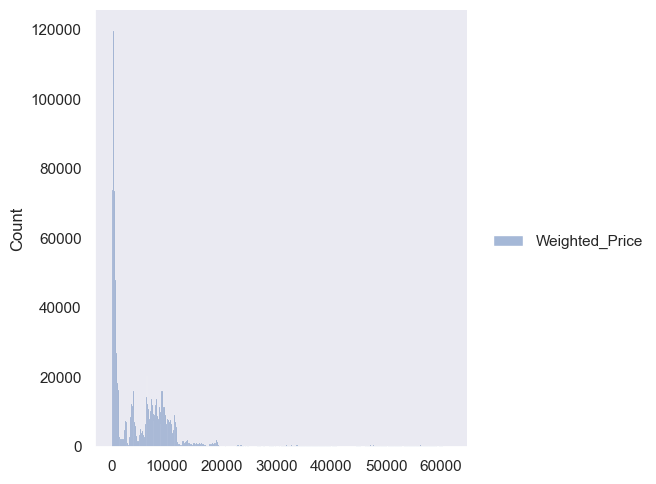

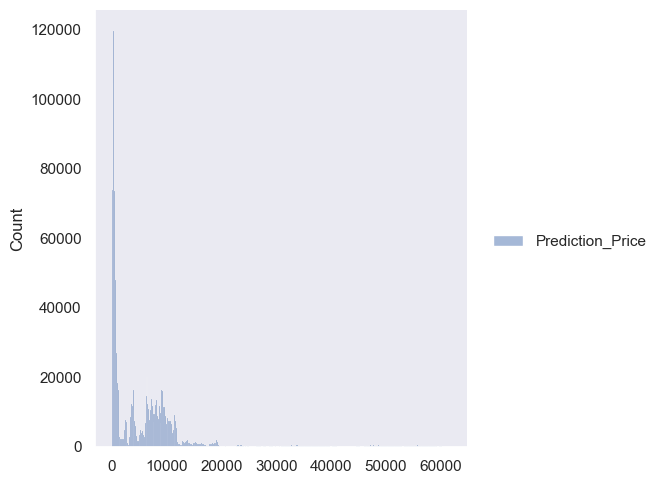

In [97]:
# Distribuição dos valores reais x previstos:
sns.set_style('dark')
ax1 = sns.displot(Y, color = 'r', label = 'Valores Reais')
sns.displot(_Y, color = 'b', label = 'Valores Previstos')

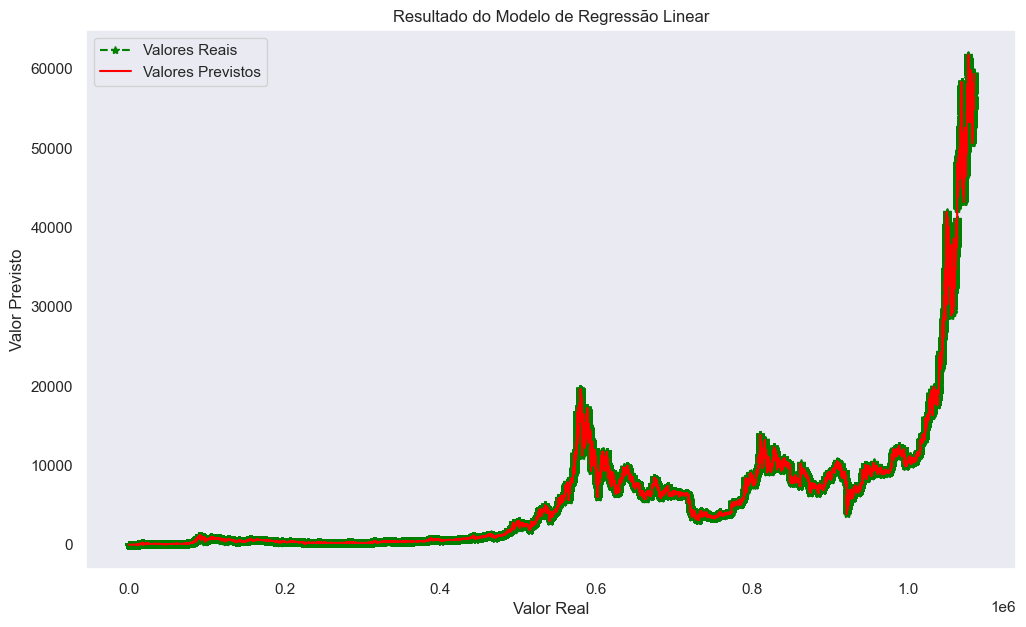

In [99]:
# Plot dos valores reais x previstos:
plt.figure(figsize=(12, 7))
plt.plot(Y, color = 'green', marker = '*', linestyle = 'dashed', label = 'Valores Reais')
plt.plot(_Y, color = 'red', label = 'Valores Previstos')
plt.title('Resultado do Modelo de Regressão Linear')
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.legend()
plt.show()

### Versão 2 - Otimização de Hiperparâmetros

In [100]:
# Criar o modelo:
modelo_lr_v2 = LinearRegression(
    featuresCol='scaled_features',
    labelCol='Weighted_Price',
    predictionCol='Prediction_Price')

In [102]:
# Criar grid para otimização de hiperparâmetros:
grid = ParamGridBuilder().addGrid(modelo_lr_v2.maxIter, [50, 100]).build()

In [103]:
# Criar o avaliador:
evaluator = RegressionEvaluator(
    labelCol='Weighted_Price',
    predictionCol='Prediction_Price',
    metricName='rmse')

In [104]:
# Criar o cross-validator: Validação cruzada
cv = CrossValidator(
    estimator=modelo_lr_v2,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    parallelism=2) # Número de threads

In [106]:
# Treinar o cross-validator:
cvModel = cv.fit(dados_treino_scaled)

In [107]:
# Extrai o melhor modelo do cross-validator:
modelo_v2 = cvModel.bestModel

In [ ]:
# Salvar o modelo em disco:
modelo_v2.write().overwrite().save('.arquivos_DSA/modelos/modelo_v2')

#### Avaliação do Modelo v2

In [108]:
# Previsões para os dados de teste:
previsoes_v2 = modelo_v2.transform(dados_teste_scaled) # Aplicando o modelo aos dados de teste

In [109]:
# Selecionar as colunas:
pred_data_v2 = previsoes_v2.select('Prediction_Price', 'Weighted_Price').show(10)

+------------------+--------------+
|  Prediction_Price|Weighted_Price|
+------------------+--------------+
| 4.504909012297221|          4.39|
| 4.694203324164685|          4.58|
|5.1023630413359795|           5.0|
| 5.433574719955553|          5.32|
| 5.385412108823919|          5.29|
|  5.39758488984133|          5.29|
| 5.303426517610845|          5.19|
| 5.465997158226096|  5.3604618117|
| 5.855180173595436|   5.777027027|
| 6.113688036802646|           6.0|
+------------------+--------------+
only showing top 10 rows



In [110]:
# Calcular o MAE (Mean Absolute Error):
print(
    "Mean Absolute Error (MAE) nos dados de teste: {:.3f}".format(
        modelo_v2.summary.meanAbsoluteError))

Mean Absolute Error (MAE) nos dados de teste: 3.390


In [111]:
evaluator = RegressionEvaluator(labelCol='Weighted_Price',
                                predictionCol='Prediction_Price',
                                metricName='rmse')

In [112]:
# Aplicar o avaliador nos dados de teste:
rmse_v2 = evaluator.evaluate(previsoes_v2)
print("Root Mean Squared Error (RMSE) nos dados de teste: %g" % rmse_v2)

Root Mean Squared Error (RMSE) nos dados de teste: 10.3786


c:\Program Files\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Program Files\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


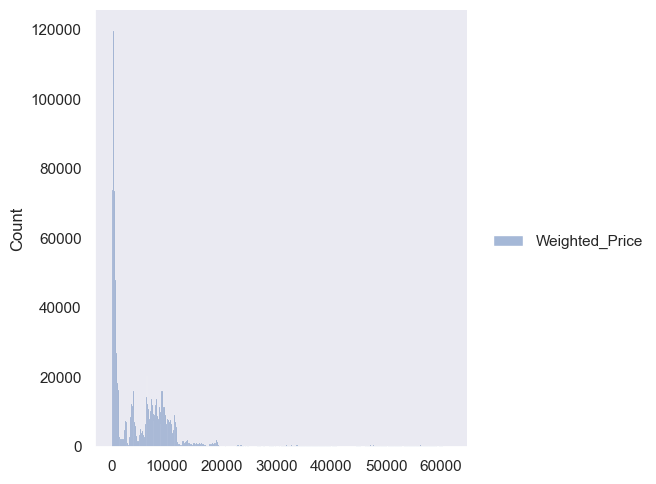

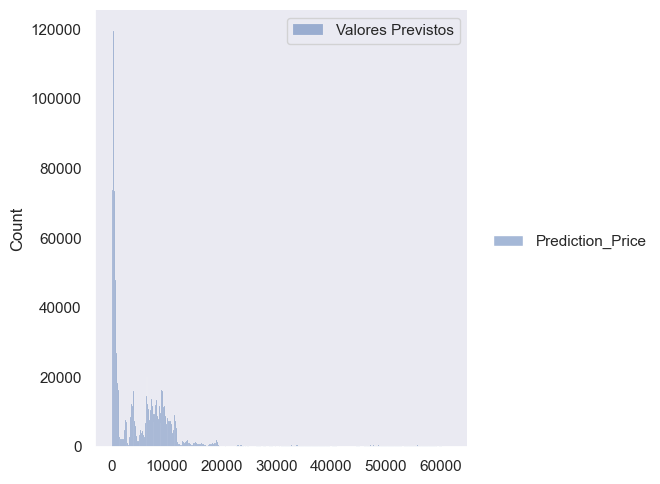

In [113]:
# Plot dos valores reais x previstos:

# Extrair as previsões:
pred_results_v2 = modelo_v2.evaluate(dados_teste_scaled)

# Valores reais de y sendo convertidos para o formato do Pandas:
Y = pred_results_v2.predictions.select('Weighted_Price').toPandas()

# Valores previstos de y sendo convertidos para o formato do Pandas:
_Y = pred_results_v2.predictions.select('Prediction_Price').toPandas()

# Plot:
sns.set_style('dark')
ax1 = sns.displot(Y, color = 'r', label = 'Valores Reais')
sns.displot(_Y, color = 'b', label = 'Valores Previstos')
plt.legend()
plt.show()

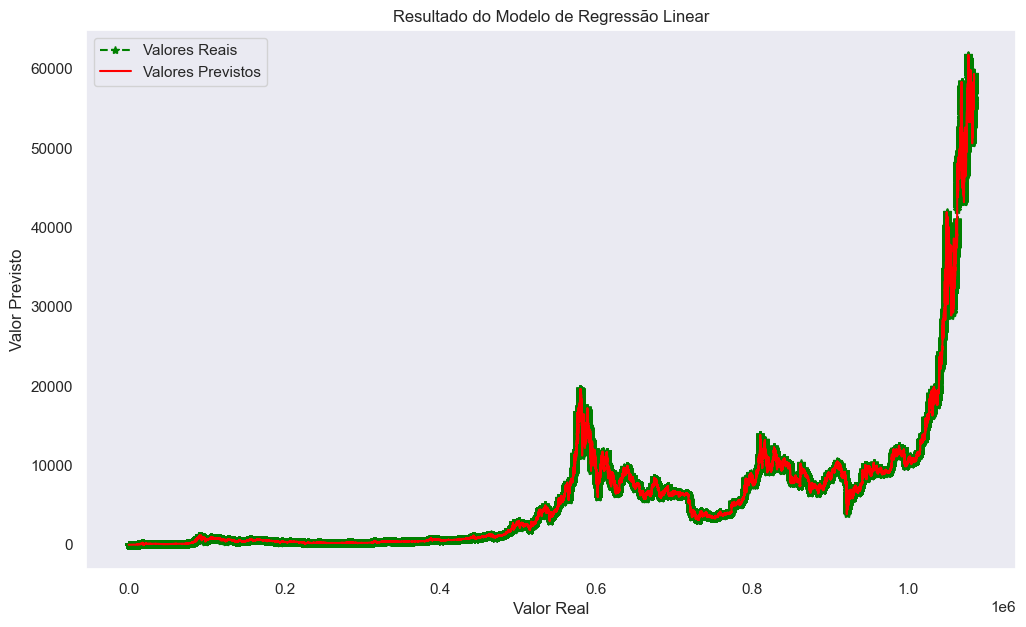

In [114]:
# Plot dos valores reais x previstos:
plt.figure(figsize=(12, 7))
plt.plot(Y, color = 'green', marker = '*', linestyle = 'dashed', label = 'Valores Reais')
plt.plot(_Y, color = 'red', label = 'Valores Previstos')
plt.title('Resultado do Modelo de Regressão Linear')
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.legend()
plt.show()

## Previsões em tempo real

In [115]:
# Novos dados para previsão:
novos_dados = [[20546.29, 3422.57, 72403082.02], [21620.85, 3271.14, 71319207.5]]

In [116]:
# Prepara o dataframe do Pandas:
df_novos_dados = pd.DataFrame(novos_dados, columns=['Open', 'Vol_BTC', 'Vol_Currency'])
df_novos_dados # Visualizar o dataframe

,Open,Vol_BTC,Vol_Currency
0,20546.29,3422.57,72403082.02
1,21620.85,3271.14,71319207.50


In [117]:
# Converter o dataframe do Pandas para o Spark:
df_novos_dados_spark = spark_session.createDataFrame(df_novos_dados)
df_novos_dados_spark.show()

+--------+-------+-------------+
|    Open|Vol_BTC| Vol_Currency|
+--------+-------+-------------+
|20546.29|3422.57|7.240308202E7|
|21620.85|3271.14| 7.13192075E7|
+--------+-------+-------------+



In [118]:
df_novos_dados_spark.printSchema()

root
 |-- Open: double (nullable = true)
 |-- Vol_BTC: double (nullable = true)
 |-- Vol_Currency: double (nullable = true)



In [119]:
# Criar vetor de atributos:
df_assembled = assembler.transform(df_novos_dados_spark) # Aplicando o assembler aos novos dados
df_assembled.show()

+--------+-------+-------------+--------------------+
|    Open|Vol_BTC| Vol_Currency|            features|
+--------+-------+-------------+--------------------+
|20546.29|3422.57|7.240308202E7|[20546.29,3422.57...|
|21620.85|3271.14| 7.13192075E7|[21620.85,3271.14...|
+--------+-------+-------------+--------------------+



In [120]:
# Normalizar os dados:
df_assembled_scaled = scalerModel.transform(df_assembled) # Aplicando o scaler aos novos dados
df_assembled_scaled.show()

+--------+-------+-------------+--------------------+--------------------+
|    Open|Vol_BTC| Vol_Currency|            features|     scaled_features|
+--------+-------+-------------+--------------------+--------------------+
|20546.29|3422.57|7.240308202E7|[20546.29,3422.57...|[0.33277893100517...|
|21620.85|3271.14| 7.13192075E7|[21620.85,3271.14...|[0.35018631093336...|
+--------+-------+-------------+--------------------+--------------------+



In [121]:
# Previsões para novos dados
previsoes_novos_dados = modelo_v1.transform(df_assembled_scaled) # Aplicando o modelo aos novos dados

In [126]:
# Visualizar as previsões:
previsoes_novos_dados.select('Prediction_Price').show()

+-----------------+
| Prediction_Price|
+-----------------+
|20538.57908638016|
| 21612.5755194858|
+-----------------+



## Encerrar a sessão Spark

In [127]:
# Encerrar a sessão Spark:
spark_session.stop()
# Encerrar o Spark Context:
sc.stop()